In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('C:/Users/20235153/Modeling & Simulation/mitbih_train.csv',header=None)
test_df=pd.read_csv('C:/Users/20235153/Modeling & Simulation/mitbih_test.csv',header=None)

In [3]:
print('Train Data Shape:', train_df.shape, '\nTest Data Shape:', test_df.shape)

Train Data Shape: (87554, 188) 
Test Data Shape: (21892, 188)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [6]:
categories_train = train_df[187].value_counts()

In [48]:
print(categories_train)

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


In [7]:
categories_test = test_df[187].value_counts()
print(categories_test)

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


In [8]:
#change the label type from float to integer
train_df[187] = train_df[187].astype(int)
test_df[187] = test_df[187].astype(int)

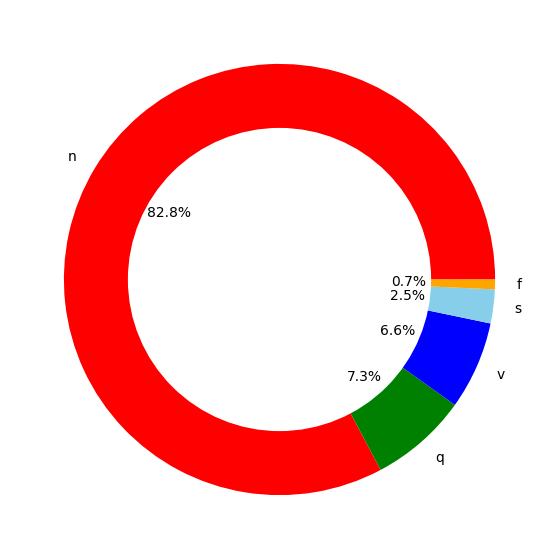

In [9]:
plt.figure(figsize=(10,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(categories_train, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Make it Binary

In [10]:
train_df[187] = [1 if i > 0 else i for i in train_df[187]]
test_df[187] = [1 if i > 0 else i for i in test_df[187]]

In [11]:
categories_1 = train_df[187].value_counts()

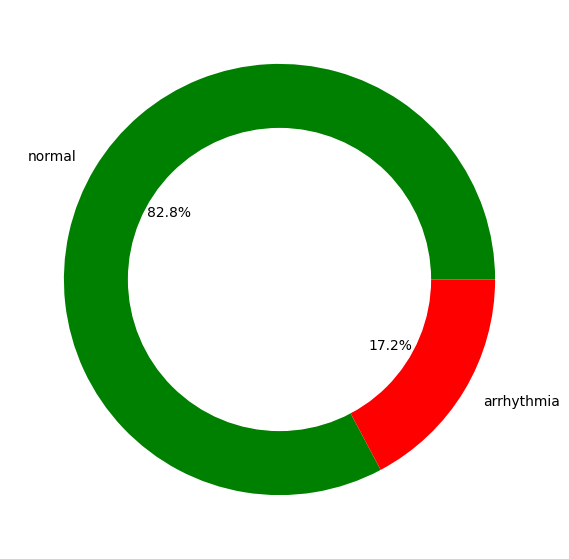

In [12]:
plt.figure(figsize=(10,7))
my_circle_1 =plt.Circle( (0,0), 0.7, color='white')
plt.pie(categories_1, labels=['normal','arrhythmia'], colors=['green','red'], autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle_1)
plt.show()

#### Adding Noise

In [13]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)

In [14]:
y_train=train_df[187]
y_test=test_df[187]

In [15]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

In [20]:
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

#### Balance Training Data with Weights

In [21]:
from sklearn.utils.class_weight import compute_class_weight

In [22]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train.ravel()), y=y_train.ravel())

In [23]:
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

#### CNN Model

In [24]:
def network(X_train,y_train,X_test,y_test, class_weights):

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(1, activation='sigmoid', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=10,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test), class_weight = class_weights)
    model.load_weights('best_model.h5')
    return(model,history)

In [25]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [26]:
import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test, class_weights_dict)

Epoch 1/10
2737/2737 [==============================] - 90s 32ms/step - loss: 0.4910 - accuracy: 0.7860 - val_loss: 0.3464 - val_accuracy: 0.8697
Epoch 2/10
2737/2737 [==============================] - 92s 34ms/step - loss: 0.4397 - accuracy: 0.8230 - val_loss: 0.6541 - val_accuracy: 0.8436
Epoch 3/10
2737/2737 [==============================] - 90s 33ms/step - loss: 0.4182 - accuracy: 0.8313 - val_loss: 0.3418 - val_accuracy: 0.8750
Epoch 4/10
2737/2737 [==============================] - 91s 33ms/step - loss: 0.3972 - accuracy: 0.8398 - val_loss: 0.3512 - val_accuracy: 0.8573
Epoch 5/10
2737/2737 [==============================] - 93s 34ms/step - loss: 0.3739 - accuracy: 0.8479 - val_loss: 0.3370 - val_accuracy: 0.8694
Epoch 6/10
2737/2737 [==============================] - 91s 33ms/step - loss: 0.3442 - accuracy: 0.8561 - val_loss: 0.4735 - val_accuracy: 0.8139
Epoch 7/10
2737/2737 [==============================] - 91s 33ms/step - loss: 0.3090 - accuracy: 0.8710 - val_loss: 0.3771 -

In [27]:
#evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

685/685 [==============================] - 6s 9ms/step


In [33]:
threshpreds = (y_pred>0.5)*1

The f1 score for the testing data: 0.4673001676914477


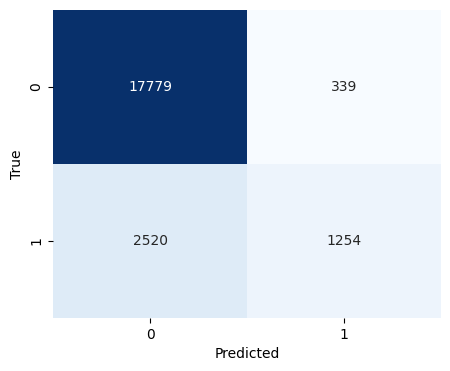

In [47]:
#Calculating and printing the f1 score 
f1_test = f1_score(y_test, threshpreds)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusio-n matrix
cf = confusion_matrix(y_test, threshpreds)
plt.figure(figsize = (5,4))
sns.heatmap(cf, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()